In [ ]:
import pandas as pd
data = pd.read_csv("train.csv")
data

,text,humor,id
0,Watch this swimmer disappear into winter storm...,0,42e466fe04c94cd18c5be40fff1c4f97
1,"They laughed at reagan, too: trump's ideas wil...",0,7840c01d01964aa78641013566828c18
2,"Hey, are you cold? go over to the corner, it's...",1,ad018a0f4d5c4f2d919c7292ebb1547d
3,Can't get a standing desk? these are almost as...,0,89616f57313d43fcb7084ade6f709d57
4,Wanna hear a joke about my penis? never mind i...,1,5df9f888d78c45f094387e8ce1da018f
...,...,...,...
159995,I want to learn how to do 3 things before i di...,1,0c532972a90747f3907b260a9897e3b8
159996,Gabrielle union on the #metoo movement: 'the f...,0,ea99552a300f44b0af973b1ace5cda46
159997,"Deodorant: ugh i hate my job, gotta go in his ...",1,561674776f6f453f9b718fe792a383d5
159998,Harvard law professor to join the race for dem...,0,fe449d646e6044aaac3a9679fd0437a1


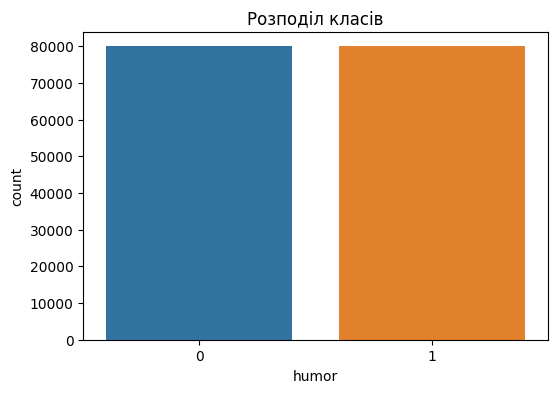

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='humor', data=data)
plt.title('Розподіл класів')
plt.show()


In [ ]:
data['humor'].value_counts()

0    80000
1    80000
Name: humor, dtype: int64

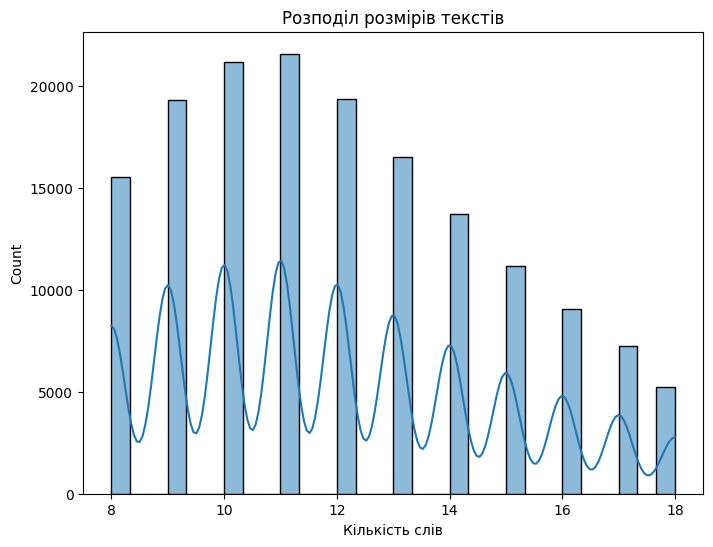

In [ ]:
data['Text_Length'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data['Text_Length'], bins=30, kde=True)
plt.title('Розподіл розмірів текстів')
plt.xlabel('Кількість слів')
plt.show()


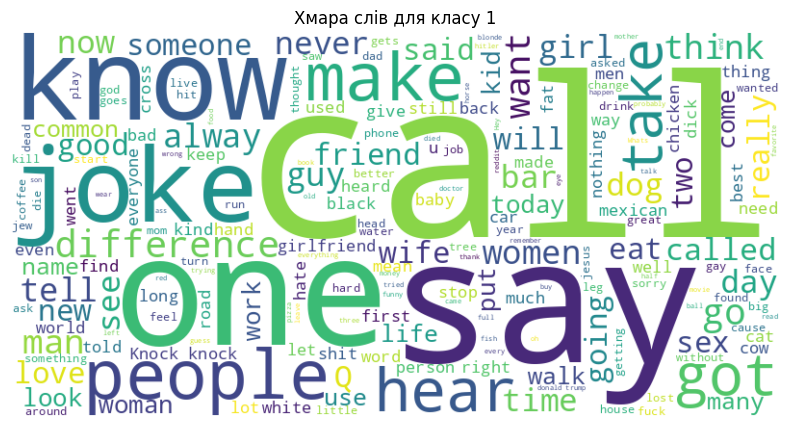

In [54]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[data['humor'] == 1]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Хмара слів для класу 1')
plt.axis('off')
plt.show()


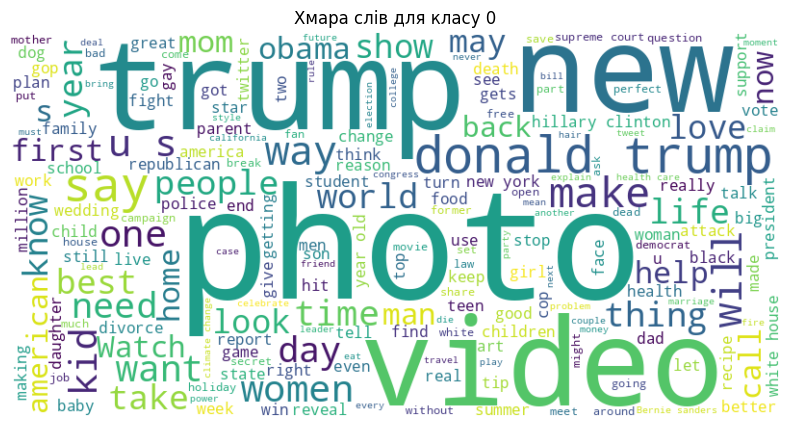

In [55]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[data['humor'] == 0]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Хмара слів для класу 0')
plt.axis('off')
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)


## LSTM algorithm with cross validation

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import numpy as np

texts = train_df['text']
labels = train_df['humor']

# Tokenize the text data
max_words = 10000  # Consider only the top 10,000 words in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_sequence_length = 20  # Set your desired sequence length
data_ = pad_sequences(sequences, maxlen=max_sequence_length)
labels = np.array(labels)

# Define the number of folds for cross-validation
n_splits = 5

stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_test_loss = []
all_test_accuracy = []
embedding_dim = 50  
lstm_units = 50  

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for train_index, test_index in stratified_kfold.split(data_, labels):
    print("Training on fold:", train_index)
    X_train, X_test = data_[train_index], data_[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    all_test_loss.append(test_loss)
    all_test_accuracy.append(test_accuracy)

# Calculate the average test loss and accuracy over all folds
average_test_loss = np.mean(all_test_loss)
average_test_accuracy = np.mean(all_test_accuracy)

print(f"Average Test Loss: {average_test_loss:.4f}, Average Test Accuracy: {average_test_accuracy:.4f}")


Training on fold: [     1      2      3 ... 127997 127998 127999]
Epoch 1/3
3200/3200 [==============================] - 50s 15ms/step - loss: 0.1785 - accuracy: 0.9286 - val_loss: 0.1509 - val_accuracy: 0.9425
Epoch 2/3
3200/3200 [==============================] - 21s 6ms/step - loss: 0.1131 - accuracy: 0.9566 - val_loss: 0.1458 - val_accuracy: 0.9451
Epoch 3/3
800/800 [==============================] - 2s 2ms/step - loss: 0.1550 - accuracy: 0.9440
Training on fold: [     0      1      2 ... 127994 127995 127999]
Epoch 1/3
3200/3200 [==============================] - 22s 7ms/step - loss: 0.0889 - accuracy: 0.9674 - val_loss: 0.0773 - val_accuracy: 0.9688
Epoch 2/3
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0624 - accuracy: 0.9769 - val_loss: 0.0919 - val_accuracy: 0.9639
Epoch 3/3
800/800 [==============================] - 2s 2ms/step - loss: 0.1136 - accuracy: 0.9598
Training on fold: [     0      2      5 ... 127997 127998 127999]
Epoch 1/3
3200/3200 [======

1000/1000 [==============================] - 2s 2ms/step
Accuracy: 94.12%


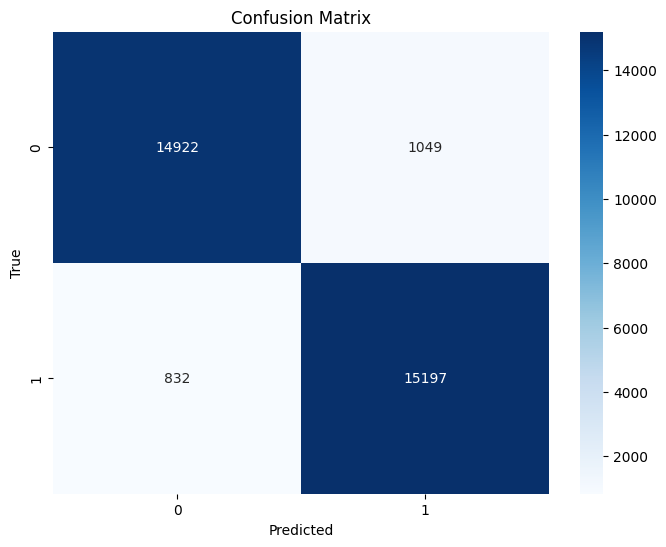

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     15971
           1       0.94      0.95      0.94     16029

    accuracy                           0.94     32000
   macro avg       0.94      0.94      0.94     32000
weighted avg       0.94      0.94      0.94     32000



In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = test_df['text']
test_labels = test_df['humor']

sequences = tokenizer.texts_to_sequences(test_texts)
data_ = pad_sequences(sequences, maxlen=max_sequence_length)
labels = np.array(test_labels)

predictions = model.predict(data_)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = labels

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(true_classes, predicted_classes))


## BERT model finetuning

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

from torch.utils.data import TensorDataset

def tokenize_texts(texts, max_length=20):
    return tokenizer(texts.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='pt')

train_inputs = tokenize_texts(train_df['text'])
test_inputs = tokenize_texts(test_df['text'])

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['humor'].tolist())
test_labels = torch.tensor(test_df['humor'].tolist())

# Create TensorDataset
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 3

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader))

criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        logits = outputs.logits
        predicted_class = logits.argmax(dim=1)
        correct_predictions += (predicted_class == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Training Accuracy: {accuracy * 100:.2f}%')
# Save the fine-tuned model if needed
torch.save(model.state_dict(), 'fine_tuned_bert_model.pth')#20 хв при batchsize = 120, при 32 лише 7 хв


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 0.0314, Training Accuracy: 98.93%
Epoch 2/4, Loss: 0.0111, Training Accuracy: 99.70%
Epoch 3/4, Loss: 0.0110, Training Accuracy: 99.71%
Epoch 4/4, Loss: 0.0112, Training Accuracy: 99.69%


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

concatenated_dataset = ConcatDataset([train_loader.dataset, test_loader.dataset])

batch_size = 32
loader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# additional training loop


num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in loader:
        # Move batch to device
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

     # Calculate training accuracy
        logits = outputs.logits
        predicted_class = logits.argmax(dim=1)
        correct_predictions += (predicted_class == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Training Accuracy: {accuracy * 100:.2f}%')
# Save the fine-tuned model if needed

Epoch 1/2, Loss: 0.0375, Training Accuracy: 99.02%
Epoch 2/2, Loss: 0.0375, Training Accuracy: 99.00%


In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    # Make predictions on the test set
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = logits.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_class.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)

print("Confusion Matrix:")
print(cm)


Test Accuracy: 98.75%
Confusion Matrix:
[[15776   195]
 [  205 15824]]


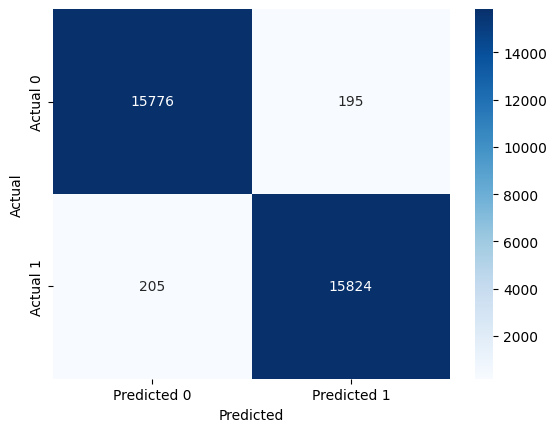

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display classification report
print(classification_report(all_labels, all_predictions))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15971
           1       0.99      0.99      0.99     16029

    accuracy                           0.99     32000
   macro avg       0.99      0.99      0.99     32000
weighted avg       0.99      0.99      0.99     32000



### Predictions for test dataset

In [40]:
data_test = pd.read_csv("test.csv")
data_test

,id,text
0,c09157401b554420b90af6d2f2a02a78,Thought up a reddit joke today. when is a tria...
1,83b965a5997b41818bc43381ba5404c1,How much do pirates pay for corn? a buck an ear!
2,80d12f4c1b9a47c783ca3f31c300d013,Hillary clinton sent her book to every gop can...
3,09c7e7b12e0f46c7a00702b830e5973a,Italian unions lambast new museum boss for wor...
4,a9c3972a3c554d609a7331cb763b9de9,Life below the ocean’s surface wholly depends ...
...,...,...
39995,7ef799f6c9854d85b3b98162d77ae892,Whats the difference between a jewish and a bl...
39996,abe544e6b75e4e168d5324969d7145fa,Hillary clinton's lawyer defends her use of pe...
39997,1ed944dc516142499ceac69a67def770,What's the best drug to have sex on? birth con...
39998,147a292cba774fc6a9687b845ff085e1,Fit links: tony horton's rules for gym success...


In [41]:

test_inputs = tokenize_texts(data_test['text'])
test_data = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])


In [42]:
len(test_data)

40000

In [43]:
from sklearn.metrics import accuracy_score

# Create DataLoader
batch_size = 32
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model.eval()
#all_labels = []
all_predictions = []

with torch.no_grad():
    # Make predictions on the test set
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = logits.argmax(dim=1)

        # Evaluate accuracy, precision, recall, etc. as needed
        #all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_class.cpu().numpy())
results_df = pd.DataFrame({'id': data_test.id, 'class': all_predictions})
results_df.to_csv('results.csv', index=False)

In [44]:
len(all_predictions)

40000

In [46]:
all_predictions.count(0)

20038